In [77]:
import vcf
import pandas as pd
from collections import defaultdict, Counter
import pysam

In [116]:
reads = list(pysam.Samfile('margin_align_longer_consensus.sam'))

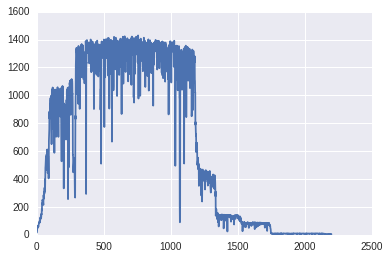

In [209]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# whats our coverage across the transcript look like?
import numpy as np
coverages = np.zeros(2202)
for a in reads:
    for read_pos, ref_pos in a.get_aligned_pairs():
        if read_pos is not None and ref_pos is not None:
            coverages[ref_pos] += 1

plt.plot(range(len(coverages)), coverages)

In [210]:
# parse VCF into intervals
# based on coverage plot, cut off at 1100 bases
recs = list(vcf.Reader(open('variants_longer.vcf')))
recs = [x for x in recs if x.POS <= 1100]
intervals = []
for r in recs:
    start, stop = r._compute_coordinates_for_indel()
    intervals.append([start - 1, stop, r])  # convert to 0-based

In [211]:
# how many distinct feature vectors are there?
feature_vectors = defaultdict(list)
for r in recs:
    for sample in r.samples[:-1]:  # exclude consensus
        gt = sample.gt_bases.split('/')[0]
        feature_vectors[sample.sample].append(gt)
        
feature_df = pd.DataFrame.from_dict(feature_vectors).T
print feature_df.drop_duplicates()

             0  1     2  3  4   5  6  7                     8  9  ... 23 24  \
NOTCH2-1      T  T  CGGC  G  G  CC  G  G           GCGGCGGAGGA  A ...  C  A   
NOTCH2NL-A-1  T  C  CGGC  G  G   C  G  G           GCGGCGGCGGA  A ...  C  G   
NOTCH2NL-A-2  T  C  CGGC  G  G   C  G  G           GCGGCGGCGGA  A ...  C  G   
NOTCH2NL-B-1  T  C     C  C  G  CC  G  G                    GA  A ...  C  G   
NOTCH2NL-B-2  T  C     C  C  G  CC  G  G                    GA  A ...  C  G   
NOTCH2NL-C-1  T  C  CGGC  G  G  CC  T  C  GCGGCGGCGGCGGCGGAGGA  C ...  C  G   
NOTCH2NL-C-2  T  C  CGGC  G  G  CC  T  C           GCGGCGGCGGC  C ...  C  G   
NOTCH2NL-D-1  C  C  CGGC  G  A  CC  G  G  GCGGCGGCGGCGGAGGAGGA  A ...  T  G   

             25 26 27 28 29 30     31 32  
NOTCH2-1      C  C  C  C  A  A  AATAA  G  
NOTCH2NL-A-1  T  T  C  C  G  A      A  A  
NOTCH2NL-A-2  C  T  C  C  G  A      A  A  
NOTCH2NL-B-1  C  T  C  C  G  A      A  A  
NOTCH2NL-B-2  C  T  C  C  G  A      A  A  
NOTCH2NL-C-1  C  T  C  C  G  A

In [212]:
results = []
for a in reads:
    r = [a.qname]
    m = {y: x for x, y in a.get_aligned_pairs()}
    for start, stop, rec in intervals:
        start = m.get(start, None)
        stop = m.get(stop, None)
        if start is not None and stop is not None:
            seq = a.seq[start:stop]
        else:
            seq = None
        r.append(seq)
    results.append(r)

# construct column names based on VCF records
columns = ['read_name']
for i, r in enumerate(recs):
    s = defaultdict(list)
    for sample in r.samples[:-1]:  # exclude consensus
        gt = sample.gt_bases.split('/')[0]  # inherently homozygous
        if 'NOTCH2-' in sample.sample: # simplify names
            name = 'N2-' + sample.sample.split('-', 1)[1]
        else:
            name = sample.sample.split('-', 1)[1]
        s[gt].append(name)
    name_str = '_'.join([':'.join([x, ','.join(y)]) for x, y in s.iteritems()])
    columns.append('{}/{}'.format(i, name_str))
        
df = pd.DataFrame(results, columns=columns)
df = df.set_index('read_name')

In [213]:
# report the counts
for col in df:
    print col, Counter(df[col]).most_common(3)

0/C:D-1,D-2_T:N2-1,N2-2,A-1,A-2,B-1,B-2,C-1,C-2 [(None, 1269), ('T', 199), ('C', 11)]
1/C:A-1,A-2,B-1,B-2,C-1,C-2,D-1,D-2_T:N2-1,N2-2 [(None, 1235), ('C', 238), ('T', 4)]
2/CGGC:N2-1,N2-2,A-1,A-2,C-1,C-2,D-1,D-2_C:B-1,B-2 [(None, 1089), ('CGGC', 269), ('CGGT', 40)]
3/C:B-1,B-2_G:N2-1,N2-2,A-1,A-2,C-1,C-2,D-1,D-2 [(None, 757), ('G', 443), ('C', 186)]
4/A:D-1,D-2_G:N2-1,N2-2,A-1,A-2,B-1,B-2,C-1,C-2 [('G', 934), (None, 511), ('A', 35)]
5/CC:N2-1,N2-2,B-1,B-2,C-1,C-2,D-1,D-2_C:A-1,A-2 [('CC', 626), (None, 520), ('C', 274)]
6/T:C-1,C-2_G:N2-1,N2-2,A-1,A-2,B-1,B-2,D-1,D-2 [('G', 828), (None, 566), ('T', 54)]
7/C:C-1,C-2_G:N2-1,N2-2,A-1,A-2,B-1,B-2,D-1,D-2 [('G', 925), (None, 484), ('C', 55)]
8/GCGGCGGCGGA:A-1,A-2_GCGGCGGCGGC:C-2_GCGGCGGAGGA:N2-1,N2-2_GCGGCGGCGGCGGAGGAGGA:D-1,D-2_GA:B-1,B-2_GCGGCGGCGGCGGCGGAGGA:C-1 [(None, 1185), ('GCGGCGGCGGA', 49), ('GCGGA', 30)]
9/A:N2-1,N2-2,A-1,A-2,B-1,B-2,D-1,D-2_C:C-1,C-2 [('A', 941), (None, 334), ('C', 185)]
10/A:A-1,A-2_G:N2-1,N2-2,B-1,B-2,C-1,C-2,D-

In [140]:
# dig into the in frame stop
tmp = Counter()
for a in reads:
    r = [a.qname]
    m = {y: x for x, y in a.get_aligned_pairs()}
    start = m.get(642, None)
    stop = m.get(643, None)
    if start is not None and stop is not None:
        seq = a.seq[start:stop]
    else:
        seq = None
    tmp[seq] += 1

In [247]:
# attempt clustering
# reduce each row into a count for each haplotype
# first construct a map of position -> base -> paralogs
para_map = defaultdict(lambda: defaultdict(set))
for i, row in feature_df.T.iterrows():
    for para, base in row.iteritems():
        para_map[i][base].add(para)

In [251]:
# now use this on the dataframe
grouped_results = defaultdict(list)
for read_id, row in df.iterrows():
    for i, (_, base) in enumerate(row.iteritems()):
        grouped_results[read_id].append(para_map[i][base])

In [264]:
# how many contain distinct groups?
counts = Counter()
for read_id, sets in grouped_results.iteritems():
    try:
        c = set.intersection(*[x for x in sets if len(x) > 0])
    except TypeError:
        continue
    if len(c) > 0:
        counts[frozenset(c)] += 1

In [238]:
# attempt to cluster
# first, replace all rare values with None
# rare values are values that appear in less than 1% of times in the column
new_df = defaultdict(list)
for col in df:
    counts = Counter(df[col])
    percents = {x: 1.0 * y / len(df) for x, y in counts.iteritems()}
    for read_id, val in df[col].iteritems():
        if percents[val] > 0.01:
            new_df[read_id].append(val)
        else:
            new_df[read_id].append(None)

new_df = pd.DataFrame.from_dict(new_df)
new_df = new_df.T
new_df.columns = df.columns

# report the counts
for col in new_df:
    print col, Counter(new_df[col]).most_common(3)

0/C:D-1,D-2_T:N2-1,N2-2,A-1,A-2,B-1,B-2,C-1,C-2 [(None, 1284), ('T', 199)]
1/C:A-1,A-2,B-1,B-2,C-1,C-2,D-1,D-2_T:N2-1,N2-2 [(None, 1245), ('C', 238)]
2/CGGC:N2-1,N2-2,A-1,A-2,C-1,C-2,D-1,D-2_C:B-1,B-2 [(None, 1152), ('CGGC', 269), ('CGGT', 40)]
3/C:B-1,B-2_G:N2-1,N2-2,A-1,A-2,C-1,C-2,D-1,D-2 [(None, 765), ('G', 443), ('C', 186)]
4/A:D-1,D-2_G:N2-1,N2-2,A-1,A-2,B-1,B-2,C-1,C-2 [('G', 934), (None, 514), ('A', 35)]
5/CC:N2-1,N2-2,B-1,B-2,C-1,C-2,D-1,D-2_C:A-1,A-2 [('CC', 626), (None, 551), ('C', 274)]
6/T:C-1,C-2_G:N2-1,N2-2,A-1,A-2,B-1,B-2,D-1,D-2 [('G', 828), (None, 601), ('T', 54)]
7/C:C-1,C-2_G:N2-1,N2-2,A-1,A-2,B-1,B-2,D-1,D-2 [('G', 925), (None, 503), ('C', 55)]
8/GCGGCGGCGGA:A-1,A-2_GCGGCGGCGGC:C-2_GCGGCGGAGGA:N2-1,N2-2_GCGGCGGCGGCGGAGGAGGA:D-1,D-2_GA:B-1,B-2_GCGGCGGCGGCGGCGGAGGA:C-1 [(None, 1351), ('GCGGCGGCGGA', 49), ('GCGGA', 30)]
9/A:N2-1,N2-2,A-1,A-2,B-1,B-2,D-1,D-2_C:C-1,C-2 [('A', 941), (None, 357), ('C', 185)]
10/A:A-1,A-2_G:N2-1,N2-2,B-1,B-2,C-1,C-2,D-1,D-2 [('G', 962), ('

In [292]:
# repeat the above counts process, using these filtered datasets
# now use this on the dataframe
grouped_results = defaultdict(list)
for read_id, row in new_df.iterrows():
    for i, (_, base) in enumerate(row.iteritems()):
        grouped_results[read_id].append(para_map[i][base])

counts_filtered = Counter()
for read_id, sets in grouped_results.iteritems():
    try:
        c = set.intersection(*[x for x in sets if len(x) > 0])
    except TypeError:
        continue
    if len(c) > 0:
        counts_filtered[frozenset(c)] += 1

In [297]:
# what about the ones that don't have a unique combination?
failed = []
for read_id, sets in grouped_results.iteritems():
    try:
        c = set.intersection(*[x for x in sets if len(x) > 0])
    except TypeError:
        continue
    if len(c) == 0:
        failed.append([read_id, sets])

In [300]:
# how many of the failed ones contain the D sets? N2 sets?
n = 0
d = 0
for read_id, sets in failed:
    if {'NOTCH2NL-D-1', 'NOTCH2NL-D-2'} in sets:
        d += 1
    elif {'NOTCH2-1', 'NOTCH2-2'} in sets:
        n += 1
print n, d

65 131


In [319]:
# how many distinct groupings of positions do we see in the failed set?
failed_ids = zip(*failed)[0]
failed_df = df[df.index.isin(failed_ids)]

# report the counts
for col in failed_df:
    print col, Counter(failed_df[col]).most_common(3)

0/C:D-1,D-2_T:N2-1,N2-2,A-1,A-2,B-1,B-2,C-1,C-2 [(None, 475), ('T', 84), ('C', 11)]
1/C:A-1,A-2,B-1,B-2,C-1,C-2,D-1,D-2_T:N2-1,N2-2 [(None, 449), ('C', 117), ('T', 2)]
2/CGGC:N2-1,N2-2,A-1,A-2,C-1,C-2,D-1,D-2_C:B-1,B-2 [(None, 370), ('CGGC', 162), ('CGGT', 14)]
3/C:B-1,B-2_G:N2-1,N2-2,A-1,A-2,C-1,C-2,D-1,D-2 [('G', 255), (None, 216), ('C', 62)]
4/A:D-1,D-2_G:N2-1,N2-2,A-1,A-2,B-1,B-2,C-1,C-2 [('G', 404), (None, 134), ('A', 32)]
5/CC:N2-1,N2-2,B-1,B-2,C-1,C-2,D-1,D-2_C:A-1,A-2 [('CC', 321), (None, 131), ('C', 94)]
6/T:C-1,C-2_G:N2-1,N2-2,A-1,A-2,B-1,B-2,D-1,D-2 [('G', 381), (None, 154), ('T', 19)]
7/C:C-1,C-2_G:N2-1,N2-2,A-1,A-2,B-1,B-2,D-1,D-2 [('G', 404), (None, 136), ('C', 21)]
8/GCGGCGGCGGA:A-1,A-2_GCGGCGGCGGC:C-2_GCGGCGGAGGA:N2-1,N2-2_GCGGCGGCGGCGGAGGAGGA:D-1,D-2_GA:B-1,B-2_GCGGCGGCGGCGGCGGAGGA:C-1 [(None, 469), ('GCGGA', 12), ('GCGGCGGCGGA', 10)]
9/A:N2-1,N2-2,A-1,A-2,B-1,B-2,D-1,D-2_C:C-1,C-2 [('A', 384), (None, 123), ('C', 62)]
10/A:A-1,A-2_G:N2-1,N2-2,B-1,B-2,C-1,C-2,D-1,D-2 [(